# Import

In [1]:
# !pip install -q rdkit
# !pip install -q albumentations
# !pip install accelerate -U
# !pip install -q tokenizer
# !pip install -q transformer
# !pip install -q tokenizers

# import accelerate
# accelerate.__version__

In [2]:
import random
import os

from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

In [3]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
class CFG:
    SEED = 0
    IMG_SIZE = 224
    BATCH_SIZE = 64
    EPOCHS = 512
    LEARNING_RATE = 0.003

<br></br>

# Data Load

In [5]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [6]:
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


<br></br>

# EDA

In [7]:
# train_df.describe()

In [8]:
# num_features = train_df.columns[train_df.dtypes!='object'].tolist()
# for i,col in enumerate(num_features):

#     fig = plt.figure(figsize=(15,7))
#     fig.add_subplot(121)
#     sns.histplot(train_df[col],bins=20)
#     plt.grid()

#     fig.add_subplot(122)
#     sns.histplot(np.log(train_df[col]+1e-3),bins=20)
#     plt.grid()

#     plt.suptitle('[{}/{}] {}'.format(i+1,len(num_features),col))
#     plt.tight_layout()
#     plt.show()

# # -> ['Molecular_Weight','Molecular_PolarSurfaceArea']

In [9]:
# cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=train_df[col],y=train_df['HLM'])
#     plt.grid()
#     plt.show()

In [10]:
# cols = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df[col],y=train_df.MLM)
#     plt.show()

In [11]:
# train_df.nunique()

In [12]:
# lists = sorted(train_df['Num_H_Acceptors'].unique())
# for v in lists:
#     print('########',v)
#     d = train_df[train_df['Num_H_Acceptors']==v]
    
#     cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
#     for col in cols:
#         print(col)
#         plt.figure(figsize=(15,7))
#         sns.scatterplot(x=d[col],y=d['HLM'])
#         plt.grid()
#         plt.show()

<br></br>

# Pre-Processing

<br>

## Set target range to [0,100]

- [Dacon](https://dacon.io/competitions/official/236127/talkboard/409051?page=1&dtype=recent)에 따르면 100이 넘는 값도 나올 수 있음

In [13]:
# targets = ['MLM','HLM']
# for t in targets:
#     train_df[t] = [0 if x<0 else
#                    100 if x>100 else
#                    x for x in train_df[t]]

<br>

## Make molecule features

In [14]:
# Molecule to MorganFingerprint
def mol2fp(mol):
    #radius, nBits = 6, 4096
    radius, nBits = 12, (2**10)*3
    fp = AllChem.GetHashedMorganFingerprint(mol, radius=radius, nBits=nBits)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [15]:
# (1) SMILES를 통해 Molecule(분자구조) 생성
PandasTools.AddMoleculeColumnToFrame(train_df,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test_df ,'SMILES','Molecule')

In [16]:
from sklearn.feature_selection import VarianceThreshold

In [17]:
# (2) Morgan Fingerprint column 추가
train_df["FPs"] = train_df.Molecule.apply(mol2fp)
test_df ["FPs"] = test_df .Molecule.apply(mol2fp)

In [18]:
# (3) Morgan Fingerprint 중, variance가 0.05보다 작은 컬럼들을 지우기
feature_select = VarianceThreshold(threshold=0.20)

# 일부사용
tr_fps_selected = feature_select.fit_transform(np.stack(train_df['FPs']))
te_fps_selected = feature_select.transform(np.stack(test_df['FPs']))
print(tr_fps_selected.shape[1])

# # 전체사용
# tr_fps_selected = np.stack(train_df['FPs'])
# te_fps_selected = np.stack(test_df ['FPs'])

fps_names = ['fps'+str(i+1) for i in range(tr_fps_selected.shape[1])]

train_df = pd.concat([train_df,pd.DataFrame(tr_fps_selected,columns=fps_names)],axis=1)
test_df  = pd.concat([test_df ,pd.DataFrame(te_fps_selected,columns=fps_names)],axis=1)

62


In [19]:
# 사용할 column만 추출
features = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors',
            'Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
fps_feature = 'FPs'
smiles_feature = 'SMILES'
targets  = ['MLM','HLM']

train_df = train_df[features+fps_names+[fps_feature,smiles_feature]+targets] #fps_names
test_df  = test_df [features+fps_names+[fps_feature,smiles_feature]]          #fps_names

In [20]:
train_df.shape

(3498, 73)

In [21]:
train_df.head()

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,...,fps57,fps58,fps59,fps60,fps61,fps62,FPs,SMILES,MLM,HLM
0,3.259,400.495,5,2,8,3.259,117.37,4,1,1,...,0,4,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680
1,2.169,301.407,2,1,2,2.172,73.47,3,1,0,...,0,4,0,1,1,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590
2,1.593,297.358,5,0,3,1.585,62.45,1,0,0,...,0,4,0,4,3,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892
3,4.771,494.652,6,0,5,3.475,92.60,3,0,0,...,0,6,2,9,3,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000
4,2.335,268.310,3,0,1,2.337,42.43,2,0,0,...,0,7,0,1,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990


<br>

## Imputaion

In [22]:
from sklearn.impute import SimpleImputer

In [23]:
def null_check(data):
    d = data.copy()
    null_info = d.isnull().sum()
    null_info = null_info[null_info!=0]
    display(null_info)

In [24]:
print('> train')
null_check(train_df)

print('> test')
null_check(test_df)

> train


AlogP    2
dtype: int64

> test


AlogP    1
dtype: int64

In [25]:
# Imputation
tr_null_loc = train_df.AlogP.isnull()
te_null_loc = test_df .AlogP.isnull()

train_df.AlogP[tr_null_loc] = train_df.LogD[tr_null_loc]
test_df .AlogP[te_null_loc] = test_df .LogD[te_null_loc]

In [26]:
print('> train')
null_check(train_df)

print('> test')
null_check(test_df)

> train


Series([], dtype: int64)

> test


Series([], dtype: int64)

<br>

## Train Test Split

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
tr_df, va_df = train_test_split(train_df,test_size=0.2,shuffle=True,random_state=CFG.SEED)
te_df = test_df.copy()

In [29]:
len(tr_df), len(va_df), len(te_df)

(2798, 700, 483)

<br>

## Scaling

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaling_features = features+fps_names
scalers = {}
for f in scaling_features:
    scaler = MinMaxScaler(feature_range=(-1,1))
    tr_df[f] = scaler.fit_transform(np.array(tr_df[f]).reshape(-1,1))
    va_df[f] = scaler.transform(np.array(va_df[f]).reshape(-1,1))
    te_df[f] = scaler.transform(np.array(te_df[f]).reshape(-1,1))
    scalers[f] = scaler

<br>

## Interaction Term

In [31]:
import warnings
from tqdm import trange

def get_abs_corr(x,y):
    return np.abs(np.corrcoef(x,y))[0,1]

class InteractionTerm:
    def __init__(self):
        pass
    
    def fit(self,data,num_features,corr_cutoff=0.7):
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        
        d = data.copy()
        self.interaction_list = []
        for i in trange(len(num_features),desc='fitting...'):
            for j in range(len(num_features)):
                if i>j:
                    col_i = num_features[i]
                    col_j = num_features[j]
                    
                    # 상관계수가 cutoff보다 큰 경우에는 interaction을 생성하지 않음
                    if (get_abs_corr(d[col_i]*d[col_j],d[col_i])>=corr_cutoff) | (get_abs_corr(d[col_i]*d[col_j],d[col_j])>=corr_cutoff):
                        pass
                    else:
                        self.interaction_list.append(f'{col_i}*{col_j}')
    
    def transform(self,data):
        d = data.copy()
        print('> the number of interaction term:',len(self.interaction_list))
        for interaction in self.interaction_list:
            col_i,col_j = interaction.split('*')
            d[interaction] = d[col_i]*d[col_j]
        return d
    
    def fit_transform(self,data,num_features,corr_cutoff=0.7):
        self.fit(data,num_features,corr_cutoff)
        return self.transform(data)

In [32]:
# num_features = features + fps_features

In [33]:
# interaction_maker = InteractionTerm()
# interaction_maker.fit(
#     data=tr_df,
#     num_features=num_features,
#     corr_cutoff=0.15,
# )
# tr_df = interaction_maker.transform(tr_df)
# va_df = interaction_maker.transform(va_df)
# te_df = interaction_maker.transform(te_df)

In [34]:
tr_df.shape

(2798, 73)

<br>

## Target Transformation

In [35]:
# for t in targets:
#     tr_df[t] = np.log(tr_df[t]+1e-3)
#     va_df[t] = np.log(va_df[t]+1e-3)

# def inverse_transform(x):
#     return torch.exp(x)-1e-3

In [36]:
# from scipy.special import boxcox, inv_boxcox

# def boxcox_transform(x):
#     _lambda = 0.25
#     return boxcox(x,_lambda)

# def inverse_boxcox_transform(x):
#     _lambda = 0.25
#     return inv_boxcox(x,_lambda)

# tr_df[targets] = tr_df[targets].apply(boxcox_transform)
# va_df[targets] = va_df[targets].apply(boxcox_transform)

In [37]:
inverse_transform = None

<br>

## Truncated SVD
- 참조 : [Kaggle](https://www.kaggle.com/code/xiafire/lb-t15-msci-multiome-catboostregressor)

In [38]:
len(fps_names)

62

In [39]:
n_components = 16

In [40]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

# features = train_df.columns.difference(CFG.TARGET+cat_features)
features = fps_names
for col in features:
    scaler = StandardScaler()
    train_df[col] = scaler.fit_transform(np.array(train_df[col]).reshape(-1,1))
    test_df [col] = scaler.transform(np.array(test_df[col]).reshape(-1,1))
    
train_input = train_df[features]
test_input  = test_df [features]

pca_input = TruncatedSVD(n_components=n_components, random_state=CFG.SEED)
train_input = pca_input.fit_transform(train_input)
test_input  = pca_input.fit_transform(test_input)
print(pca_input.explained_variance_ratio_.sum())

train_df.drop(features,axis=1,inplace=True)
test_df .drop(features,axis=1,inplace=True)

for i,(tr_value,te_value) in enumerate(zip(train_input.T,test_input.T)):
    train_df[f'tsvd_{i+1}'] = tr_value
    test_df [f'tsvd_{i+1}'] = te_value

0.637733933201836


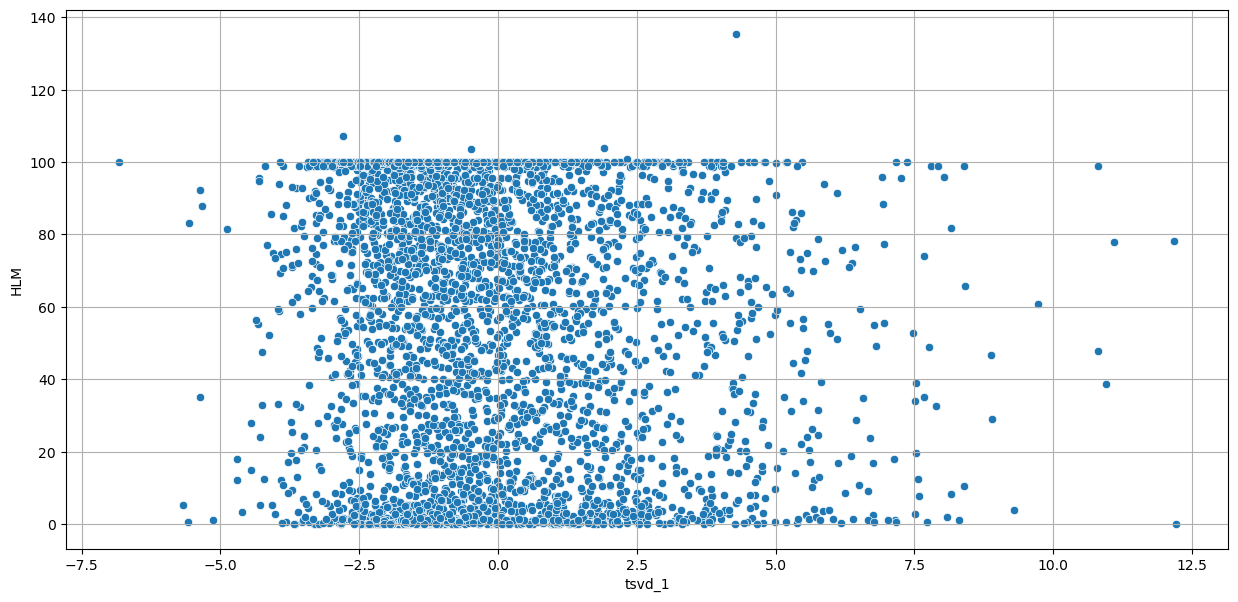

In [41]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=train_df['tsvd_1'],y=train_df['HLM'])
plt.grid()
plt.show()

<br></br>

# Tokenizer Save

In [42]:
def mkdir(paths):
    if isinstance(paths,str):
        paths = [paths]
    for path in paths:
        if not os.path.exists(path):
            os.mkdir(path)

In [43]:
train_df['SMILES'].to_csv('./out/smiles.txt',index=False,header=False)

## Huggingface Tokenizer
- [참조](https://wikidocs.net/99893)

In [53]:
from tokenizers.implementations import ByteLevelBPETokenizer, BertWordPieceTokenizer, CharBPETokenizer, SentencePieceBPETokenizer
from tokenizers.processors import BertProcessing

In [54]:
# ByteLevelBPETokenizer, BertWordPieceTokenizer, CharBPETokenizer, SentencePieceBPETokenizer
Tokenizer = ByteLevelBPETokenizer
Tokenizer_name = Tokenizer.__name__
mkdir('./mc/{}'.format(Tokenizer_name))

In [55]:
# (1) ByteLevelBPETokenizer
vocab_size = 200
special_tokens = ["<s>","<PAD>","<MASK>"]

tokenizer = Tokenizer(lowercase=False)
tokenizer.train('./out/smiles.txt', vocab_size=vocab_size, min_frequency=1, special_tokens=special_tokens)
tokenizer.save_model('./mc/{}'.format(Tokenizer_name))

tokenizer = Tokenizer(
    "./mc/{}/vocab.json".format(Tokenizer_name),
    "./mc/{}/merges.txt".format(Tokenizer_name),
)

tokenizer._tokenizer.post_processor = BertProcessing(
    ("<PAD>" , tokenizer.token_to_id("<PAD>")),
    ("<MASK>", tokenizer.token_to_id("<MASK>")),
)

tokenizer.enable_padding(length=200)
tokenizer.save

<bound method BaseTokenizer.save of Tokenizer(vocabulary_size=259, model=ByteLevelBPE, add_prefix_space=False, lowercase=False, dropout=None, unicode_normalizer=None, continuing_subword_prefix=None, end_of_word_suffix=None, trim_offsets=False)>

In [56]:
# # (2) BertWordPieceTokenizer
# vocab_size = 200
# special_tokens = ["<s>","<PAD>","<MASK>"]

# tokenizer = Tokenizer(lowercase=False)
# tokenizer.train('./out/smiles.txt', vocab_size=vocab_size, min_frequency=1, special_tokens=special_tokens)
# tokenizer.save_model('./mc/{}'.format(Tokenizer_name))

In [57]:
# # (3) CharBPETokenizer
# vocab_size = 200
# special_tokens = ["<s>","<PAD>","<MASK>","<unk>"]

# tokenizer = Tokenizer(lowercase=False)
# tokenizer.train('./out/smiles.txt', vocab_size=vocab_size, min_frequency=1, special_tokens=special_tokens)
# tokenizer.save_model('./mc/{}'.format(Tokenizer_name))

# tokenizer = Tokenizer(
#     "./mc/{}/vocab.json".format(Tokenizer_name),
#     "./mc/{}/merges.txt".format(Tokenizer_name),
# )

# tokenizer._tokenizer.post_processor = BertProcessing(
#     ("<PAD>" , tokenizer.token_to_id("<PAD>")),
#     ("<MASK>", tokenizer.token_to_id("<MASK>")),
# )

# tokenizer.enable_padding(length=200)
# tokenizer.save

In [58]:
# # (4) SentencePieceBPETokenizer
# vocab_size = 200
# special_tokens = ["<s>","<PAD>","<MASK>"]

# tokenizer = Tokenizer()
# tokenizer.train('./out/smiles.txt', vocab_size=vocab_size, min_frequency=1, special_tokens=special_tokens)
# tokenizer.save_model('./mc/{}'.format(Tokenizer_name))

(check)

In [59]:
# s = tr_df.SMILES.values[0]
# print(s)
# encoded = tokenizer.encode(s)
# for token,ids in zip(encoded.tokens,encoded.ids):
#     print(token,ids)

In [60]:
# ids_list = []
# for s in tqdm(te_df.SMILES.values):
#     encoded = tokenizer.encode(s)
#     ids_list.append(encoded.ids)

<br>

## SmilesPE & selfies
- [참조](https://xinhaoli74.github.io/SmilesPE/), [Github](https://github.com/XinhaoLi74/SmilesPE/blob/master/Examples/train_SPE.ipynb)
- → embedding model train이 필요함

In [61]:
# import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [62]:
# !pip install -q SmilesPE
# !pip install -q selfies

In [63]:
# from SmilesPE.pretokenizer import kmer_tokenizer
# import selfies

In [64]:
# import codecs
# from SmilesPE.learner import *

# smiles = train_df['SMILES']
# output = codecs.open('./out/SPE_ChEMBL.txt', 'w')
# learn_SPE(smiles, output, num_symbols=200, min_frequency=1, augmentation=1, verbose=True, total_symbols=True)

In [65]:
# from SmilesPE.tokenizer import *

# spe_vob = codecs.open('./out/SPE_ChEMBL.txt')
# spe = SPE_Tokenizer(spe_vob)

# smi = 'CC[N+](C)(C)Cc1ccccc1Br'
# spe.tokenize(smi)

In [66]:
# smiles = train_df['SMILES'].values
# s = smiles[0]
# # s = 'CC[N+](C)(C)Cc1ccccc1Br'
# kmer_tokenizer(selfies.encoder(s),ngram=4)

<br></br>

# Custom Dataset

In [67]:
from rdkit import Chem
from rdkit.Chem import Draw

class CustomDataset(Dataset):
    def __init__(self, data, targets, smiles, fps, fps_maximum, tokenizer, transforms=[None,None], is_test=False):
        self.data = data.copy()
        self.targets = targets
        self.smiles = smiles
        self.fps = fps
        self.tokenizer = tokenizer
        self.smiles_transforms, self.fps_transforms = transforms
        self.is_test = is_test
        
        self.smiles_features = []
        for s in tqdm(data[smiles].values,desc='Setup SMILES... '):
            m = Chem.MolFromSmiles(s)
            img = Draw.MolToImage(m)#, size=(224,224))
            img = np.array(img)
            if self.smiles_transforms is not None:
                img = self.smiles_transforms(image=img)['image']
            self.smiles_features.append(img)
        self.smiles_features = torch.stack(self.smiles_features)
        
        fps_values = (np.stack(data[fps])/fps_maximum)*255 # max -> 255
        self.fps_features = []
        for f in fps_values:
            img = f.reshape(32,32,3)
            if self.fps_transforms is not None:
                img = self.fps_transforms(image=img)['image']
            self.fps_features.append(img)
        
        self.embedding = []
        for s in data[smiles].values:
            encoded = self.tokenizer.encode(s)
            self.embedding.append(encoded.ids)
            
        if not self.is_test:
            self.target_features = self.data[self.targets].values
            self.num_features = self.data.drop(columns=targets+[fps,smiles],axis=1).values
        else:
            self.num_features = self.data.drop(columns=[fps,smiles],axis=1).values

    def __getitem__(self, index):
        if self.is_test:
            return (
                torch.Tensor(self.num_features[index]),
                torch.Tensor(self.smiles_features[index]),
                torch.Tensor(self.fps_features[index]),
                torch.tensor(self.embedding[index]),
            )
        else:
            return (
                torch.Tensor(self.num_features[index]),
                torch.Tensor(self.smiles_features[index]),
                torch.Tensor(self.fps_features[index]),
                torch.tensor(self.embedding[index]),
                torch.Tensor(self.target_features[index]),
            )
        
    def __len__(self):
        return len(self.data)

In [68]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

In [69]:
# import matplotlib.pyplot as plt

# # (1) smiles
# s = tr_df['SMILES'].values[0]
# m = Chem.MolFromSmiles(s)
# img = Draw.MolToImage(m)#, size=(224,224))
# img = np.array(img)
# img = smiles_transform(image=img)['image']
# img.shape
# plt.imshow(img.T)

# # (2) fps
# fps_maximum = max(np.stack(tr_df.FPs).max(),np.stack(te_df.FPs).max())
# fps_value = (np.stack(tr_df['FPs'])/fps_maximum)*255 # max -> 255

# f = fps_value[0]
# img = f.reshape(32,32,3)
# img = img.astype(np.float32)
# img = fps_transform(image=img)['image']
# plt.imshow(img.T)

In [70]:
#  이미지 변환
smiles_transform = A.Compose([
    A.Resize(CFG.IMG_SIZE,CFG.IMG_SIZE),
    A.ToGray(p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2(),
])

fps_transform = A.Compose([
    A.Resize(CFG.IMG_SIZE,CFG.IMG_SIZE),
    #A.ToGray(p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2(),
])

In [71]:
fps_maximum = max(np.stack(tr_df.FPs).max(),np.stack(te_df.FPs).max())
transform = [smiles_transform,fps_transform]

train_dataset = CustomDataset(tr_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, tokenizer, transform, False)
val_dataset   = CustomDataset(va_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, tokenizer, transform, False)
test_dataset  = CustomDataset(te_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, tokenizer, transform, True)

Setup SMILES... : 100%|██████████| 483/483 [00:04<00:00, 117.52it/s]


In [72]:
CFG.BATCH_SIZE = 64

In [73]:
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
val_loader   = DataLoader(val_dataset  , batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
test_loader  = DataLoader(test_dataset , batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)

In [91]:
# [feat for feat,mol,fps,emb,target in train_loader][0]
# [mol for feat,mol,fps,emb in test_loader][0]

In [92]:
# import matplotlib.pyplot as plt

# _img = [fps for feat,mol,fps,target in train_loader][0][0].numpy()
# plt.imshow(_img.T)

<br></br>

# Modeling

## Define Model

In [93]:
import torchvision.models as models
from copy import deepcopy

In [94]:
# class MultiTaskModel(nn.Module):
#     def __init__(self, feature_input_size, output_size, hidden_size, dropout_rate):
#         super(MultiTaskModel, self).__init__()
#         self.feature_output_size = 500
#         self.dropout_rate = dropout_rate
        
#         # BatchNorm1d
#         self.feature_layer = nn.Sequential(
#             nn.Linear(feature_input_size,hidden_size),
#             #nn.BatchNorm1d(hidden_size),
#             nn.LeakyReLU(0.1),
#             #nn.Dropout(self.dropout_rate),
            
#             nn.Linear(hidden_size,hidden_size),
#             #nn.BatchNorm1d(hidden_size),
#             nn.LeakyReLU(0.1),
#             #nn.Dropout(self.dropout_rate),
            
#             # nn.Linear(hidden_size,hidden_size),
#             # nn.BatchNorm1d(hidden_size),
#             # nn.LeakyReLU(0.1),
#             # nn.Dropout(self.dropout_rate),
            
#             # nn.Linear(hidden_size,hidden_size),
#             # nn.BatchNorm1d(hidden_size),
#             # nn.LeakyReLU(0.1),
#             # nn.Dropout(self.dropout_rate),
            
#             # nn.Linear(hidden_size,hidden_size),
#         )
#         self.mlm_layer = deepcopy(self.feature_layer)
#         self.hlm_layer = deepcopy(self.feature_layer)
        
#         fc_input_size = 2*hidden_size
#         self.fc = nn.Sequential(
#             nn.Linear(fc_input_size,fc_input_size//2),
#             #nn.BatchNorm1d(fc_input_size//2),
#             nn.LeakyReLU(0.1),
#             #nn.Dropout(self.dropout_rate),
#             # nn.Linear(fc_input_size//2,fc_input_size//4),
#             # nn.BatchNorm1d(fc_input_size//4),
#             # nn.LeakyReLU(0.1),
#             # nn.Dropout(self.dropout_rate),
#             # nn.Linear(fc_input_size//4,fc_input_size//8),
#             # nn.BatchNorm1d(fc_input_size//8),
#             # nn.LeakyReLU(0.1),
#             # nn.Dropout(self.dropout_rate),
#             nn.Linear(fc_input_size//2,output_size),
#         )
        
#     def forward(self, feat, mol, fps):
        
#         mlm = self.mlm_layer(feat)
#         hlm = self.hlm_layer(feat)
        
#         combined = torch.cat((mlm,hlm),dim=1)
#         combined = self.fc(combined)
        
#         output = combined
        
#         # output = self.tanh(output)
#         # output = (output+1)/2
        
#         #output = self.sigmoid(output)
        
#         return output

In [95]:
# class MultiTaskModel(nn.Module):
#     def __init__(self, feature_input_size, output_size, hidden_size, dropout_rate):
#         super(MultiTaskModel, self).__init__()
#         self.feature_output_size = 1000
#         self.dropout_rate = dropout_rate
        
#         # BatchNorm1d
#         self.feature_layer = nn.Sequential(
#             nn.Linear(feature_input_size,hidden_size),
#             nn.BatchNorm1d(hidden_size),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(self.dropout_rate),
#             nn.Linear(hidden_size,hidden_size),
#             nn.BatchNorm1d(hidden_size),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(self.dropout_rate),
#             nn.Linear(hidden_size,hidden_size),
#             nn.BatchNorm1d(hidden_size),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(self.dropout_rate),
#             nn.Linear(hidden_size,hidden_size),
#             nn.BatchNorm1d(hidden_size),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(self.dropout_rate),
#             nn.Linear(hidden_size,self.feature_output_size),
#         )
        
#         fc_input_size = self.feature_output_size
#         self.fc = nn.Sequential(
#             nn.Linear(fc_input_size,fc_input_size//2),
#             nn.BatchNorm1d(fc_input_size//2),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(self.dropout_rate),
#             nn.Linear(fc_input_size//2,fc_input_size//4),
#             nn.BatchNorm1d(fc_input_size//4),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(self.dropout_rate),
#             nn.Linear(fc_input_size//4,fc_input_size//8),
#             nn.BatchNorm1d(fc_input_size//8),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(self.dropout_rate),
#             nn.Linear(fc_input_size//8,output_size),
#         )
        
#     def forward(self, feat, mol, fps):
#         feat = self.feature_layer(feat)
#         #mol = self.mol_layer(mol)
#         #fps = self.fps_layer(fps)
#         feat = self.fc(feat)
        
#         output = feat
        
#         # output = self.tanh(output)
#         # output = (output+1)/2
        
#         #output = self.sigmoid(output)
        
#         return output

In [96]:
# class MultiTaskModel(nn.Module):
#     def __init__(self, feature_input_size, output_size, hidden_size, dropout_rate):
#         super(MultiTaskModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.dropout_rate = dropout_rate
#         self.image_output_size = 50
#         self.feature_output_size = 100
        
#         self.lstm1 = nn.LSTM(feature_input_size,hidden_size,num_layers=1,batch_first=True)
#         self.lstm2 = nn.LSTM(hidden_size,hidden_size,num_layers=1,batch_first=True)
#         self.lstm3 = nn.LSTM(hidden_size,hidden_size,num_layers=1,batch_first=True)
#         self.fc = nn.Linear(hidden_size,output_size)
#         self.bn = nn.BatchNorm1d(hidden_size)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.activation = nn.LeakyReLU(0.01)

#     def forward(self, feat, mol, fps):
#         x = feat
#         h0 = torch.zeros(1, self.hidden_size).to(x.device) 
#         c0 = torch.zeros(1, self.hidden_size).to(x.device)
        
#         x, (hn,cn) = self.lstm1(x,(h0,c0))
#         x = self.dropout(x)
#         x = self.bn(x)
#         x = self.activation(x)
        
#         x, (hn,cn) = self.lstm2(x,(hn,cn))
#         x = self.dropout(x)
#         x = self.bn(x)
#         x = self.activation(x)
        
#         x, (hn,cn) = self.lstm3(x,(hn,cn))
#         x = self.dropout(x)
#         x = self.bn(x)
#         x = self.activation(x)
        
#         x = self.fc(x)

#         return x

In [128]:
# class MultiTaskModel(nn.Module):
#     def __init__(self, feature_input_size, output_size, hidden_size, dropout_rate):
#         super(MultiTaskModel, self).__init__()
#         self.image_output_size = 50
#         self.feature_output_size = 100
#         self.dropout_rate = dropout_rate
        
#         self.activation = nn.Tanh()
        
#         # # efficientnet
#         # self.backbone = models.efficientnet_b0(pretrained=True)
#         # self.backbone.classifier = nn.Sequential(
#         #     nn.Dropout(p=0.2,inplace=True),
#         #     nn.Linear(self.backbone.classifier[-1].in_features,self.image_output_size),
#         # )
        
#         # resnet
#         self.backbone = models.resnet50(pretrained=True)
#         self.backbone.fc = nn.Linear(self.backbone.fc.in_features,self.image_output_size)
        
#         self.mol_backbone = deepcopy(self.backbone)
#         self.fps_backbone = deepcopy(self.backbone)
        
#         self.mol_layer = nn.Sequential(
#             self.mol_backbone,
#             #nn.BatchNorm1d(self.image_output_size),
#             #self.activation,
#             #nn.Dropout(self.dropout_rate),
#         )
#         self.fps_layer = nn.Sequential(
#             self.fps_backbone,
#             #nn.BatchNorm1d(self.image_output_size),
#             #self.activation,
#             #nn.Dropout(self.dropout_rate),
#         )
        
#         self.feature_layer = nn.Sequential(
#             nn.Linear(feature_input_size,hidden_size),
#             #nn.BatchNorm1d(hidden_size),
#             self.activation,
#             #nn.Dropout(self.dropout_rate),
#             nn.Linear(hidden_size,self.feature_output_size),
#         )
        
#         combined_input_size = self.feature_output_size # 2*self.image_output_size+
#         self.lstm = nn.LSTM(combined_input_size, combined_input_size//4, num_layers=2, batch_first=True)
#         self.fc = nn.Linear(combined_input_size//4,output_size)
        
#     def forward(self, feat, mol, fps):
#         feat = self.feature_layer(feat)
#         mol = self.mol_layer(mol)
#         fps = self.fps_layer(fps)
#         combined = torch.cat((feat,mol,fps),dim=1)
#         combined, _ = self.lstm(combined)
#         combined = self.activation(combined)
#         combined = self.fc(combined)
#         return combined

In [164]:
class MultiTaskModel(nn.Module):
    def __init__(self, feature_input_size, vocab_size, output_size, hidden_size, dropout_rate):
        super(MultiTaskModel, self).__init__()
        self.image_output_size = 50
        self.feature_output_size = 100
        self.embedding_output_size = 100
        self.dropout_rate = dropout_rate
        
        # efficientnet
        self.backbone = models.efficientnet_b1(pretrained=True)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(self.backbone.classifier[-1].in_features,self.image_output_size),
        )
        
        # # resnet
        # self.backbone = models.resnet50(pretrained=True)
        # self.backbone.fc = nn.Linear(self.backbone.fc.in_features,self.image_output_size)
        
        self.mol_layer = deepcopy(self.backbone)
        self.fps_layer = deepcopy(self.backbone)
        
        # BatchNorm1d, LayerNorm
        self.feature_layer = nn.Sequential(
            nn.Linear(feature_input_size,hidden_size),
            nn.LayerNorm(hidden_size),
            nn.SiLU(),#nn.LeakyReLU(0.01),
            nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size,hidden_size),
            nn.LayerNorm(hidden_size),
            nn.SiLU(),#nn.LeakyReLU(0.01),
            nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size,self.feature_output_size),
        )
        
        self.emb_layer = nn.Embedding(vocab_size, hidden_size)
        self.emb_sequence = nn.Sequential(
            #nn.BatchNorm1d(hidden_size),
            nn.SiLU(),#nn.LeakyReLU(0.01),
            #nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size, self.embedding_output_size),
        )
        
        fc_input_size = self.feature_output_size + self.embedding_output_size + self.image_output_size
        self.fc_mlm = nn.Sequential(
            nn.Linear(fc_input_size,hidden_size),
            nn.LayerNorm(hidden_size),
            nn.SiLU(),#nn.LeakyReLU(0.01),
            nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size,1),
        )
        self.fc_hlm = nn.Sequential(
            nn.Linear(fc_input_size,hidden_size),
            nn.LayerNorm(hidden_size),
            nn.SiLU(),#nn.LeakyReLU(0.01),
            nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size,1),
        )
        
    def forward(self, feat, mol, fps, emb):
        feat = self.feature_layer(feat)
        mol = self.mol_layer(mol)
        #fps = self.fps_layer(fps)
        emb = self.emb_layer(emb).mean(dim=1)
        emb = self.emb_sequence(emb)
        
        combined = torch.cat((feat,mol,emb),dim=1)
        mlm_pred = self.fc_mlm(combined)
        hlm_pred = self.fc_hlm(combined)
        
        output = torch.cat((mlm_pred,hlm_pred),dim=1)
        
        # output = self.tanh(output)
        # output = (output+1.0)/2.0
        # output = output*100.0
        
        # output = self.sigmoid(output)
        # output = output*100
        
        return output

<br>

## Training

In [165]:
class MultiRMSELoss(nn.Module):
    def __init__(self):
        super(MultiRMSELoss, self).__init__()

    def forward(self, output, target):
        loss1 = torch.sqrt(torch.mean((output[:,0]-target[:,0])**2))
        loss2 = torch.sqrt(torch.mean((output[:,1]-target[:,1])**2))
        loss = 0.5*loss1+0.5*loss2
        return loss

In [166]:
import gc
import numpy as np
import torch
import torch.nn as nn
import time

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if self.path!='':
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

        
def train(
    model, criterion, optimizer, train_loader, valid_loader, epochs,
    early_stopping, device='cpu', scheduler=None, metric_period=1, verbose=True, 
    save_model_path = './mc/best_model.pt', final_model_path = './mc/final_model.pt',
    use_best_model=True,
    inverse_transform=None,
    progress_bar=True,
):  
    seed_everything(CFG.SEED)
    model.to(device)

    best_loss  = 999999999
    best_epoch = 1
    best_model = None
    is_best    = np.nan
    
    start_time = time.time()
    epoch_s = time.time()
    
    model.train()
    for epoch in range(1, epochs+1):
        gc.collect()
        
        if progress_bar:
            pbar = tqdm(train_loader)
        else:
            pbar = train_loader
        
        #model.train()
        train_loss = []
        for feat,mol,fps,emb,target in pbar:
            feat = feat.to(device)
            mol = mol.to(device)
            fps = fps.to(device)
            emb = emb.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(feat,mol,fps,emb).float()
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)
            
            loss = criterion(output, target)
            loss.backward()  # Getting gradients
            optimizer.step() # Updating parameters

            train_loss.append(loss.item())

        if valid_loader is not None:
            valid_loss = validation(model, valid_loader, criterion, device, inverse_transform, progress_bar)
        else:
            valid_loss = loss
            
        epoch_e = time.time()
            
        if scheduler is not None:
            scheduler.step(valid_loss)

        # update the best epoch & best loss
        if (best_loss > valid_loss) | (epoch==1):
            best_epoch = epoch
            best_loss = valid_loss
            best_model = model
            is_best = 1
            torch.save(best_model.state_dict(), save_model_path)
        else:
            is_best = 0
            if not use_best_model:
                torch.save(best_model.state_dict(), save_model_path)
            
        # 결과물 printing
        if (verbose) & (epoch % metric_period == 0):
            mark = '*' if is_best else ' '
            epoch_str = str(epoch).zfill(len(str(epochs)))
            if valid_loader is not None:
                progress = '{}[{}/{}] loss: {:.5f}, val_loss: {:.5f}, best_epoch: {}, elapsed: {:.2f}s, total: {:.2f}s, remaining: {:.2f}s'\
                    .format(
                        mark,
                        epoch_str,
                        epochs,
                        np.mean(train_loss),
                        valid_loss,
                        best_epoch,
                        epoch_e-epoch_s,
                        epoch_e-start_time,
                        (epoch_e-epoch_s)*(epochs-epoch)/metric_period,
                    )
            else:
                progress = '{}[{}/{}] loss: {:.5f}, best_epoch: {}, elapsed: {:.2f}s, total: {:.2f}s, remaining: {:.2f}s'\
                    .format(
                        mark,
                        epoch_str,
                        epochs,
                        np.mean(train_loss),
                        best_epoch,
                        epoch_e-epoch_s,
                        epoch_e-start_time,
                        (epoch_e-epoch_s)*(epochs-epoch)/metric_period,
                    )
            epoch_s = time.time()
            print(progress)

        # early stopping 여부를 체크. 현재 과적합 상황 추적
        if early_stopping is not None:
            early_stopping(valid_loss, model)
            if early_stopping.early_stop:
                break
                
        torch.save(best_model.state_dict(), final_model_path)

    return best_model

def validation(model, valid_loader, criterion, device, inverse_transform, progress_bar):
    if progress_bar:
        pbar = tqdm(valid_loader)
    else:
        pbar = valid_loader
    valid_loss = []
    with torch.no_grad():
        for feat,mol,fps,emb,target in pbar:
            feat = feat.to(device)
            mol = mol.to(device)
            fps = fps.to(device)
            emb = emb.to(device)
            target = target.to(device)
            
            output = model(feat,mol,fps,emb).float()
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)

            loss = criterion(output, target)
            valid_loss.append(loss.item())

    return np.mean(valid_loss)

In [167]:
feature_input_size = [feat for feat,mol,fps,emb,target in train_dataset][0].shape[0]
output_size = 2
hidden_size = 32
dropout_rate = 0.0

In [168]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [169]:
CFG.LEARNING_RATE = 0.003

In [170]:
CFG.__dict__

mappingproxy({'__module__': '__main__',
              'SEED': 0,
              'IMG_SIZE': 224,
              'BATCH_SIZE': 64,
              'EPOCHS': 512,
              'LEARNING_RATE': 0.003,
              '__dict__': <attribute '__dict__' of 'CFG' objects>,
              '__weakref__': <attribute '__weakref__' of 'CFG' objects>,
              '__doc__': None})

In [171]:
model = MultiTaskModel(feature_input_size,vocab_size,output_size,hidden_size,dropout_rate)
# for name,param in model.named_parameters():
#     if 'backbone' in name:
#         param.requires_grad = False

criterion = MultiRMSELoss()
# optimizer= torch.optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)#, weight_decay=5e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(), lr=CFG.LEARNING_RATE, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-7, verbose=True)
scheduler = None
# early_stopping = EarlyStopping(patience=10,verbose=False,path='')
early_stopping = None

In [173]:
torch.cuda.empty_cache(), gc.collect()

(None, 0)

In [174]:
best_model = train(
    model, criterion, optimizer, train_loader, val_loader,
    CFG.EPOCHS, early_stopping, device, scheduler,
    metric_period=1, verbose=True,
    save_model_path='./mc/best_model.pt',
    final_model_path='./mc/final_model.pt',
    use_best_model=True,
    inverse_transform=inverse_transform,
    progress_bar=False,
)

*[001/512] loss: 55.18837, val_loss: 53.80200, best_epoch: 1, elapsed: 20.46s, total: 20.46s, remaining: 10456.69s
*[002/512] loss: 52.06623, val_loss: 50.15103, best_epoch: 2, elapsed: 20.77s, total: 41.53s, remaining: 10591.59s
*[003/512] loss: 47.96681, val_loss: 45.75060, best_epoch: 3, elapsed: 20.77s, total: 62.60s, remaining: 10574.19s
*[004/512] loss: 43.53042, val_loss: 41.50803, best_epoch: 4, elapsed: 20.76s, total: 83.64s, remaining: 10548.57s
*[005/512] loss: 39.72595, val_loss: 38.38078, best_epoch: 5, elapsed: 20.77s, total: 104.70s, remaining: 10530.28s
*[006/512] loss: 37.28323, val_loss: 36.76472, best_epoch: 6, elapsed: 20.83s, total: 125.81s, remaining: 10540.57s
*[007/512] loss: 36.18854, val_loss: 36.27880, best_epoch: 7, elapsed: 20.89s, total: 146.98s, remaining: 10551.92s
*[008/512] loss: 35.85063, val_loss: 36.10210, best_epoch: 8, elapsed: 21.00s, total: 168.29s, remaining: 10585.01s
 [009/512] loss: 35.75780, val_loss: 36.10877, best_epoch: 8, elapsed: 20.91

KeyboardInterrupt: 

<br></br>

# Inference

In [ ]:
def predict(best_model,loader,device,inverse_transform):
    best_model.to(device)

    true_list = []
    pred_list = []
    with torch.no_grad():
        for feat,mol,fps,emb,target in iter(loader):
            feat = feat.to(device)
            mol = mol.to(device)
            fps = fps.to(device)
            emb = emb.to(device)
            target = target.to(device)

            output = best_model(feat,mol,fps,emb)
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)

            true_list.append(target)
            pred_list.append(output)

    trues = torch.cat(true_list,dim=0)
    preds = torch.cat(pred_list,dim=0)

    trues = trues.cpu().numpy()
    preds = preds.cpu().numpy()

    return trues, preds

def predict_test(best_model,loader,device,inverse_transform):
    best_model.to(device)

    #true_list = []
    pred_list = []
    with torch.no_grad():
        for feat,mol,fps,emb in iter(loader):
            feat = feat.to(device)
            mol = mol.to(device)
            fps = fps.to(device)
            emb = emb.to(device)
            #target = target.to(device)

            output = best_model(feat,mol,fps,emb)
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                #target = inverse_transform(target)

            #true_list.append(target)
            pred_list.append(output)

    #trues = torch.cat(true_list,dim=0)
    preds = torch.cat(pred_list,dim=0)

    #trues = trues.cpu().numpy()
    preds = preds.cpu().numpy()

    return preds

In [ ]:
best_model = MultiTaskModel(feature_input_size,vocab_size,output_size,hidden_size,dropout_rate)
best_model.load_state_dict(torch.load('./mc/best_model.pt'))

In [ ]:
tr_true, tr_pred = predict(best_model,train_loader,device,inverse_transform)
va_true, va_pred = predict(best_model,val_loader,device,inverse_transform)

In [ ]:
(MultiRMSELoss()(torch.tensor(tr_true),torch.tensor(tr_pred)),
 MultiRMSELoss()(torch.tensor(va_true),torch.tensor(va_pred)))

In [ ]:
# tr_pred = tr_pred.mean(axis=1).tolist()
# tr_pred = np.array([tr_pred,tr_pred]).T

# va_pred = va_pred.mean(axis=1).tolist()
# va_pred = np.array([va_pred,va_pred]).T

# (MultiRMSELoss()(torch.tensor(tr_true),torch.tensor(tr_pred)),
#  MultiRMSELoss()(torch.tensor(va_true),torch.tensor(va_pred)))

In [ ]:
tr_true[:10].round(1), tr_pred[:10].round(1)
# va_true[:10].round(1), va_pred[:10].round(1)

In [ ]:
def abline(intercept,slope):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle='--', color='red')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
abline(0,1)
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()
fig.add_subplot(122)
sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
abline(0,1)
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()
plt.suptitle('train',fontsize=20)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
abline(0,1)
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()
fig.add_subplot(122)
sns.scatterplot(x=va_true[:,1],y=va_pred[:,1])
abline(0,1)
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()
plt.suptitle('validation',fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
te_pred = predict_test(best_model,test_loader,device,inverse_transform)

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[targets] = te_pred
submit.head()

In [ ]:
submit.to_csv('./out/mlt_efficientnet_mol&fps.csv',index=False)